In [52]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf

/usr/local/lib/python3.8/dist-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [53]:
IMG_SIZE = [512, 512]
DATASET_DIR="/home/jupyter/mnt/datasets/uw_dataset"

In [54]:
def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        #print(f'diff: {diff}')
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize))
        
#     img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
#     img = img.astype('float32') # original is uint16
#     mx = np.max(img)
#     if mx:
#         img/=mx # scale image to [0, 1]
    return img
def load_msk(path, size=IMG_SIZE):
    msk = np.load(path)
#     msk = msk.astype('float32')
#     msk/=255.0
#     msk = cv2.resize(msk, dsize=size, interpolation=cv2.INTER_NEAREST)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((*resize, 3))
    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')
    
def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path, size=size)
        imgs[..., i]+=img
    return imgs

In [55]:
df = pd.read_csv('/home/jupyter/mnt/datasets/uw_dataset/mask/train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks

df['image_path']=df.image_path.str.replace("/kaggle/input/uw-madison-gi-tract-image-segmentation",DATASET_DIR)
df['mask_path']=df.mask_path.str.replace("/kaggle/input/uwmgi-mask-dataset",DATASET_DIR+'/mask')

df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/home/jupyter/mnt/datasets/uw_dataset/train/ca...,266,266,/home/jupyter/mnt/datasets/uw_dataset/mask/np/...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/home/jupyter/mnt/datasets/uw_dataset/train/ca...,266,266,/home/jupyter/mnt/datasets/uw_dataset/mask/np/...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/home/jupyter/mnt/datasets/uw_dataset/train/ca...,266,266,/home/jupyter/mnt/datasets/uw_dataset/mask/np/...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/home/jupyter/mnt/datasets/uw_dataset/train/ca...,266,266,/home/jupyter/mnt/datasets/uw_dataset/mask/np/...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/home/jupyter/mnt/datasets/uw_dataset/train/ca...,266,266,/home/jupyter/mnt/datasets/uw_dataset/mask/np/...,"[, , ]",0,True


In [56]:
len(df)

38496

In [57]:
!ls ./images | wc -l

ls: cannot access './images': No such file or directory
0


In [58]:
!ls ./masks | wc -l

ls: cannot access './masks': No such file or directory
0


In [59]:
channels=3
stride=2
for i in range(channels):
    df[f'image_path_{i:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
df.image_paths[0]

['/home/jupyter/mnt/datasets/uw_dataset/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/home/jupyter/mnt/datasets/uw_dataset/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png',
 '/home/jupyter/mnt/datasets/uw_dataset/train/case123/case123_day20/scans/slice_0005_266_266_1.50_1.50.png']

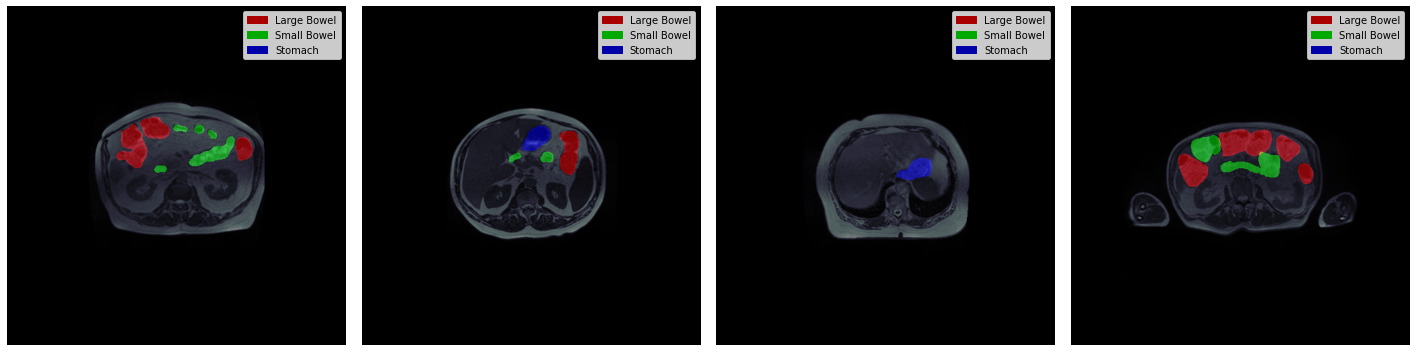

In [60]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[df['empty']==0].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = df[df['id']==id_]
    img = load_img(idf.image_path.iloc[0])
    mask = load_msk(idf.mask_path.iloc[0])
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

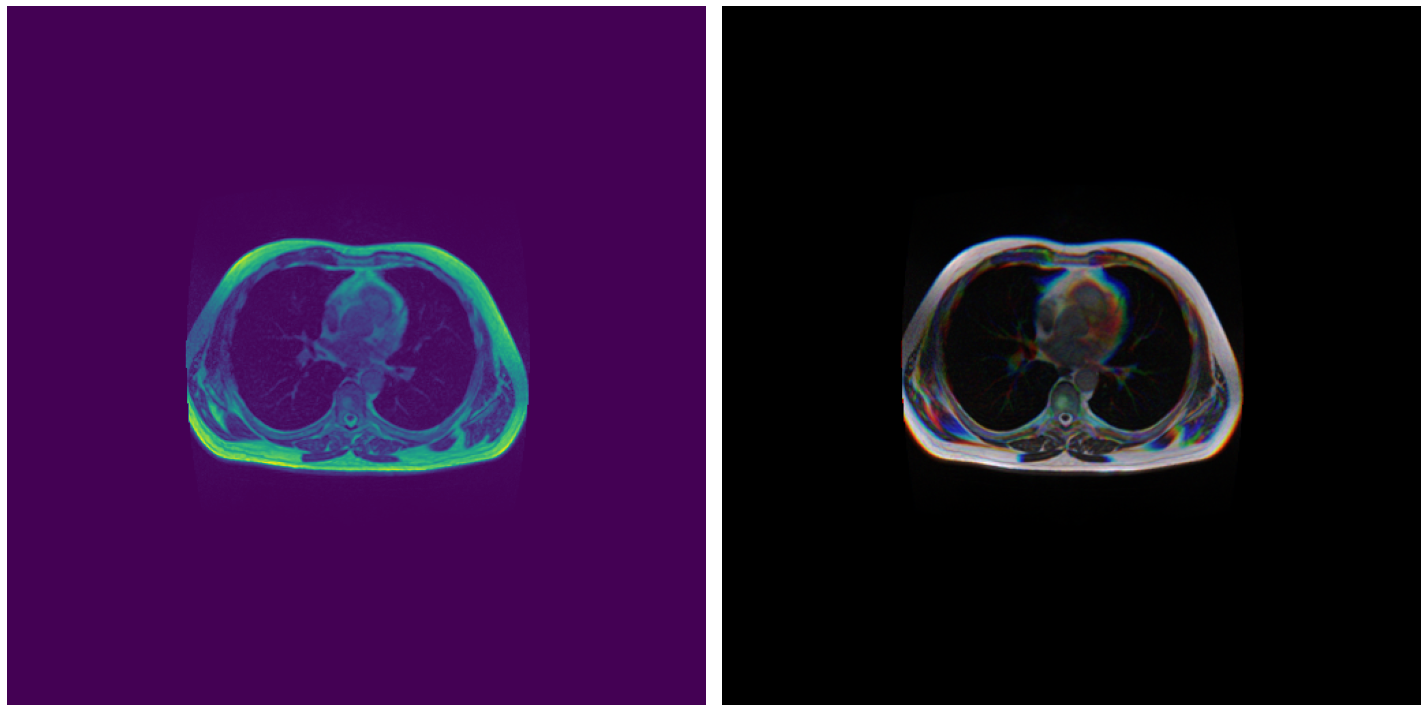

In [61]:
idx = 40

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(df.image_path[idx]).astype('float32')
img/=img.max()
plt.imshow(img)
plt.axis('off')


plt.subplot(1, 2, 2)
imgs = load_imgs(df.image_paths[idx]).astype('float32')
imgs/=imgs.max(axis=(0,1))
plt.imshow(imgs)
plt.axis('off')

plt.tight_layout()
plt.show()

In [62]:
#n0 = 0

def save_mask(id_):
    #global n0
    #n0 = n0 + 1
    #if n0<17770:
    #    return
    
    row = df[df['id']==id_].squeeze()
    
    img_paths = row.image_paths
    imgs = load_imgs(img_paths)
    np.save(f'{IMAGE_DIR}/{id_}.npy', imgs)
    
    msk_path = row.mask_path
    msk = load_msk(msk_path)
    np.save(f'{MASK_DIR}/{id_}.npy', msk)
    
    return

In [63]:
IMAGE_DIR = '/home/jupyter/work/resources/images'
MASK_DIR = '/home/jupyter/work/resources/masks'
!!mkdir -p $IMAGE_DIR
!!mkdir -p $MASK_DIR

[]

In [64]:
ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_)\
                                             for id_ in tqdm(ids, total=len(ids)))

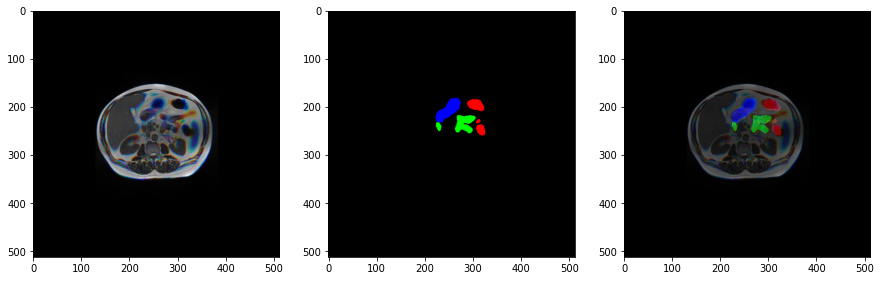

In [65]:
plt.figure(figsize=(15, 5))

imgs = np.load(f'{IMAGE_DIR}/case123_day0_slice_0080.npy').astype('float32')
imgs/=imgs.max(axis=(0,1))

plt.subplot(1, 3, 1)
plt.imshow(imgs)

msk = np.load(f'{MASK_DIR}/case123_day0_slice_0080.npy').astype('float32')
msk/=255.0

plt.subplot(1, 3, 2)
plt.imshow(msk)


plt.subplot(1, 3, 3)
plt.imshow(imgs)
plt.imshow(msk, alpha=0.5)

In [66]:
df.to_csv('/home/jupyter/work/resources/archives/train.csv',index=False)

In [67]:
shutil.make_archive('/home/jupyter/work/resources/archives/images',
                    'zip',
                    '/home/jupyter/work/resources/',
                    'images')

'/home/jupyter/work/resources/archives/images.zip'

In [68]:
shutil.make_archive('/home/jupyter/work/resources/archives/masks',
                    'zip',
                    '/home/jupyter/work/resources/',
                    'masks')

'/home/jupyter/work/resources/archives/masks.zip'